In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from _do_calculation import solve_mbes_general, solve_mbes, solve_mbes_without_cavity, get_pulses_from_cavity_field, solve_mbes_wait, solve_mbes_only_decay, solve_obes
from _mbes import mbes, mbes_soc, mbes_soc_no_cavity, mbes_soc_det, obes_soc, mbes_masing
import matplotlib
# matplotlib.use('NbAgg')
import numpy as np
from scipy.stats import logistic
from scipy.optimize import basinhopping
from scipy.special import erf
from scipy import interpolate
from IPython.display import clear_output, Javascript, Markdown
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import scipy.io
import gc
import datetime
import time
import random
import matplotlib
from _create_pdf import create_spins, create_spins_inhomo_g
from _helper_functions import get_thermal_photons, tsallis, cauchy, find_nearest, odeintz, find_nearest_sorted_left, fsolvez
from _steady_state import a_steady, a_steady_maser, a_steady_maser_temp, sz_steady_maser_from_a2, sz_steady_maser_from_a2_temp,  a2_steady_maser, ada_steady_maser_cumulant_with_filter_cav, funcada_maser_cumulant_with_filter
from importlib import reload
import _spin_params as spin_pars
import _sys_helpers
_sys_helpers.copy_connection_file()
# matplotlib.pyplot.switch_backend('nbagg')

In [2]:
# %qtconsole
gcoll = spin_pars.gcoll
q = spin_pars.q
quali = spin_pars.quali
fr = spin_pars.fr
kappa = np.pi*fr/quali  # HWHM
delta = spin_pars.delta  # detuning cavity to spin central frequency ws-wc
deltac = spin_pars.deltac  # detuning drive to cavity wc-wp
gperp = spin_pars.gperp  # HWHM
gpar = spin_pars.gpar  # 0.001 #HWHM
gammaq = spin_pars.gammaq
nbins = 701  # spin_pars.nbins  # 701#5000#20
g_number = spin_pars.g_number  # how many bins for inhomogeneous coupling
#g0 = gcoll/sqrt(nspins)
print(kappa)

3.751201656087927


In [3]:
def pulse_rwa(t, args):
    wgrund = args[0]
    fcomps = args[1]
    pulse = 0
    for i in range(len(fcomps)):
        pulse = pulse+(fcomps[i])*np.sin((i+1)*wgrund*t)
    return pulse


def pulse_rwa_gauss(t, args):
    wgrund = args[0]
    fcomps = args[1]
    nfcomps = len(fcomps)
    tend = np.pi/wgrund

    width = 2*tend/(nfcomps+5)
    t0 = 3*width/2
    pulse = 0
    for i in range(len(fcomps)):
        pulse += fcomps[i]*np.exp(-4*(t-t0)**2*np.log(2)/width**2)
        t0 += 0.5*width
    pulse *= logistic.cdf(t, loc=0.01, scale=.002) * \
        (1-logistic.cdf(t, loc=tend-0.01, scale=.002))
    pulse *= 0.46971947398573455
    return pulse


def pulse_rwa_gauss_const(t, args):
    wgrund = args[0]
    fcomps = args[1]
    maxampl = args[2]
    tend = np.pi/wgrund

    spline = 0
    for i in range(len(fcomps)):
        spline += (fcomps[i])*np.sin((i+1)*wgrund*t)
    pulsei = 0
    pulseq = 0
    pulse = 0
    pulse = maxampl*logistic.cdf(t, loc=0.02, scale=0.004) * \
        (1-logistic.cdf(t, loc=tend-0.02, scale=0.004))

    pulsei = pulse*np.cos(spline)
    pulseq = pulse*np.sin(spline)

    return pulsei, pulseq

In [4]:
def g_inhomo_function(x, sigma):
    return np.exp(-x**2/sigma**2)


x_start = 5
x_stop = 20  # µm
x = np.linspace(x_start, x_stop, g_number)
sigma = 5
g_temp = g_inhomo_function(x, sigma)
g_list = g_temp/np.sum(g_temp)

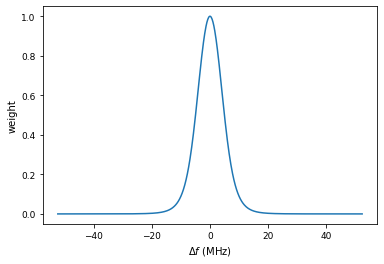

28.464147186343517
Cooperativity is: 9.228580


In [5]:
plt.close('all')
matplotlib.interactive(False)
spins, gs, pdf = create_spins_inhomo_g(
    gcoll, g_list, q, delta, gammaq, nbins, holes=False, inhomo=True, hyperfine=True)
plt.figure()
plt.plot(spins[:len(pdf)], pdf/max(pdf))
plt.xlabel('$\Delta f$ (MHz)')
plt.ylabel('weight')
plt.show()
# %qtconsole
print(gcoll)
coop = gcoll**2/kappa*np.sum(pdf/(gperp+1j*2*np.pi*spins))
print("Cooperativity is: %f" % coop.real)

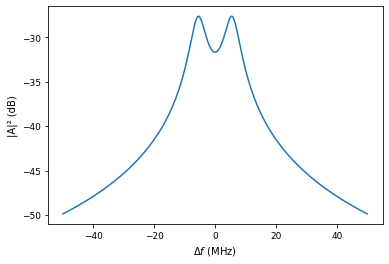

In [6]:
plt.close('all')
matplotlib.interactive(False)

initsteady = (0.001, 0.001)
fstart = 50
deltaarr = np.linspace(-fstart*2*np.pi, fstart*2*np.pi, 2000)
etasteady = 0.00001
losasteady = np.zeros(np.shape(deltaarr))
losareal = np.zeros(np.shape(deltaarr))
losaimag = np.zeros(np.shape(deltaarr))

newinit = initsteady
for i, delt in enumerate(deltaarr):

    ar, ai = a_steady(etasteady, delt, gs, spins, gpar, gperp, kappa, newinit)
    newinit = (ar, ai)
    losasteady[i] = ai**2+ar**2
    losareal[i] = ar
    losaimag[i] = ai

fig = plt.figure()
plt.xlabel('$\Delta f$ (MHz)')
plt.ylabel('|A|² (dB)')
plt.plot(deltaarr/2/np.pi, 10*np.log10(losasteady/0.0000000001))
plt.show()
#deltaarr[find(losasteady == max(losasteady))]/2/pi

# Optical Pumping

In [7]:
pump_initsteady = (0.5, 0.5)

pump_ratio = 1

pump_len = 10
iter_len = 10

pump_array = np.linspace(0.005, 1e-6, pump_len)*2*np.pi
to_iterate = 'quality'

if to_iterate == 'quality':
    # *2*np.pi #qaulity factor
    iterate_array = np.linspace(200, 2000, iter_len)
    iterate_scale_value = 1
    iterate_label = 'Quality Factor'
    iterate_unit = ''

elif to_iterate == 'temperature':
    iterate_array = np.linspace(0.01, 10, iter_len)  # temperature
    iterate_scale_value = 1
    iterate_label = 'Temperature (K)'
    iterate_unit = "K"

elif to_iterate == 'coupling':
    iterate_array = np.linspace(0.1, 5, iter_len)*2*np.pi  # coupling
    iterate_scale_value = 2*np.pi
    iterate_label = 'Coupling (MHz)'
    iterate_unit = "MHz"

elif to_iterate == 'linewidth':
    iterate_array = np.linspace(1, 80, iter_len)*2*np.pi  # linewidth
    iterate_scale_value = 2*np.pi
    iterate_label = 'Linewidth (MHz)'
    iterate_unit = "MHz"


losa2steady_maser = np.zeros((len(iterate_array), len(pump_array)))
losszsteady_maser = np.zeros(losa2steady_maser.shape)
coop_maser = np.zeros(losa2steady_maser.shape)
coop_pump_maser = np.zeros(losa2steady_maser.shape)
etasteady = 1e-12

nbar = 0
kappa_loop = np.pi*fr/quali
gcoll_loop = gcoll
gammaq_loop = gammaq

newinit = pump_initsteady
for i, iterval in enumerate(iterate_array):

    if to_iterate == 'quality':
        kappa_loop = np.pi*fr/iterval
    elif to_iterate == 'temperature':
        nbar = get_thermal_photons(fr, iterval)
    elif to_iterate == 'coupling':
        gcoll_loop = iterval
    elif to_iterate == 'linewidth':
        gammaq_loop = iterval

    spins_loop, gs_loop, pdf_loop = create_spins_inhomo_g(
        gcoll_loop, g_list, q, delta, gammaq_loop, nbins, holes=False, inhomo=True, hyperfine=True)

    for j, pump in enumerate(pump_array):
        pump_up = pump_ratio*pump
        pump_down = (1-pump_ratio)*pump
        ar, ai = a_steady_maser_temp(nbar, pump_up, etasteady, deltac, gs_loop, spins_loop,
                                     gpar+pump_down, gperp, kappa_loop, newinit)
        newinit = (ar, ai)
        coop = np.real(
            gcoll_loop**2/kappa_loop*np.sum(pdf_loop/(gperp+1j*2*np.pi*spins_loop)))
        coop_maser[i, j] = coop
        coop_pump_maser[i, j] = ((2*nbar+coop+1)/(coop-1))*(gpar+pump_down) / \
            pump_up
        a2 = ar**2+ai**2
        losa2steady_maser[i, j] = a2
        losszsteady_maser[i, j] = np.sum(sz_steady_maser_from_a2_temp(a2, nbar, pump_up, etasteady, deltac, gcoll_loop, spins_loop,
                                                                      gpar+pump_down, gperp, kappa_loop)*pdf)
    newinit = pump_initsteady

sumval = np.sum(pdf_loop/(gperp+1j*2*np.pi*spins_loop))
if to_iterate == 'quality':
    kappa_asymp = gcoll**2*sumval * \
        (1-2*pump_ratio)/(2*nbar*(pump_ratio-1)-1)
    asymp = np.pi*fr/kappa_asymp
elif to_iterate == 'temperature':
    asymp = np.nan
elif to_iterate == 'linewidth':
    asymp = np.nan
elif to_iterate == 'coupling':
    asymp = 1/2/np.pi*np.sqrt(kappa+2*kappa*nbar-2*kappa*nbar *
                              pump_ratio)/np.sqrt(2*pump_ratio*sumval-sumval)

/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


minimum value is: 281.104 


/usr/local/lib/python3.10/dist-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


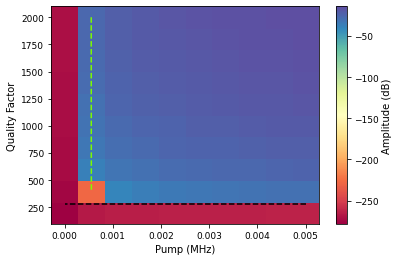

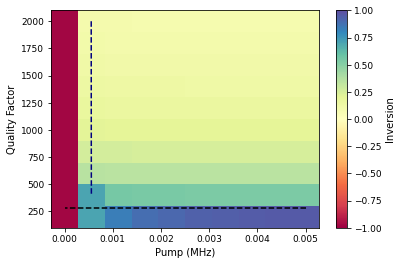

In [8]:
plt.close('all')
matplotlib.interactive(False)
fig = plt.figure()
# plt.yscale('log')
# plt.xscale('log')
plt.xlabel('Pump (MHz)')
#plt.ylabel('$\mathrm{g_{coll}}$ (MHz)')
plt.ylabel(iterate_label)


c = plt.pcolor(pump_array/2/np.pi, iterate_array/iterate_scale_value,
               10*np.log10(losa2steady_maser), cmap='Spectral')

# plt.plot([0, pump_array[-1]/2/np.pi],
#         [quali, quali], 'k-')
cb = fig.colorbar(c)
cb.set_label("Amplitude (dB)")

idxs = np.where(coop_pump_maser < 0)
coop_pump_maser[idxs] = np.inf

plt.contour(pump_array/2/np.pi, iterate_array/iterate_scale_value,
            coop_pump_maser, levels=(1,), colors='lawngreen', linestyles='--')

plt.plot([pump_array[0]/2/np.pi, pump_array[-1]/2/np.pi],
         [asymp, asymp], 'k--')

# plt.savefig('/home/andreas/pump_vs_quali_amp.png')

fig = plt.figure()
plt.xlabel('Pump (MHz)')
#plt.ylabel('$\mathrm{g_{coll}}$ (MHz)')
plt.ylabel(iterate_label)
c = plt.pcolormesh(pump_array/2/np.pi, iterate_array/iterate_scale_value,
                   losszsteady_maser, cmap='Spectral', vmin=-1, vmax=1)
# plt.yscale('log')
# plt.xscale('log')
#level = 0.2
# cs = plt.contour(pump_array/2/np.pi, quali_array,
#                 losszsteady_maser, levels=(-level, level), colors='k', linestyles='-')
#labels = plt.clabel(cs, (level, -level), inline=True, fontsize=8)
#
#[l.set_rotation(0) for l in labels]
cb = fig.colorbar(c)
cb.set_label("Inversion")
plt.contour(pump_array/2/np.pi, iterate_array/iterate_scale_value,
            coop_pump_maser, levels=(1,), colors='navy', linestyles='--')

plt.plot([pump_array[0]/2/np.pi, pump_array[-1]/2/np.pi],
         [asymp, asymp], 'k--')

# plt.plot([pump_array[0], pump_array[-1]/2/np.pi],
#         [quali, quali], 'k-')
# plt.savefig('/home/andreas/pump_vs_quali_inv.png')
if not np.isnan(asymp):
    print("minimum value is: %.3f %s" % (asymp.real, iterate_unit))
plt.show()

In [ ]:
losa2steady_maser_cum = np.zeros((len(iterate_array), len(pump_array)))
losszsteady_maser_cum = np.zeros(losa2steady_maser_cum.shape)

initcum = np.ones(nbins+2, dtype=np.complex128)
initcum[2:].real = 4*pump_up/gs_loop
initcum[2:].imag = 0

initcum[0] = 0
initcum[1] = 0
newinit = initcum

newinit = initcum

deltaf0 = 0
g_f = 0.1
kappa_f = 0.1

nbar = 0
kappa_loop = np.pi*fr/quali
gcoll_loop = gcoll
gammaq_loop = gammaq

ctr = 0
for i, iterval in enumerate(iterate_array):

    if to_iterate == 'quality':
        kappa_loop = np.pi*fr/iterval
    elif to_iterate == 'temperature':
        nbar = get_thermal_photons(fr, iterval)
    elif to_iterate == 'coupling':
        gcoll_loop = iterval
    elif to_iterate == 'linewidth':
        gammaq_loop = iterval

    spins_loop, gs_loop, pdf_loop = create_spins_inhomo_g(
        gcoll_loop, g_list, q, delta, gammaq_loop, nbins, holes=False, inhomo=True, hyperfine=True)

    for j, pump in enumerate(pump_array):
        print("Calculating %d from %d" % (ctr+1, pump_len*iter_len), end="\r")
        pump_up = pump_ratio*pump
        pump_down = (1-pump_ratio)*pump
        ret, infodict, ier, message = ada_steady_maser_cumulant_with_filter_cav(nbar, pump_up, deltac, gs_loop,
                                                                                spins_loop, gpar+pump_down, gperp, kappa_loop, kappa_f, g_f, deltaf0, newinit)
        newinit = ret

        losa2steady_maser_cum[i, j] = ret[0].real
        losszsteady_maser_cum[i, j] = np.sum(-((gpar+pump_down)-pump_up+4*gs_loop*(ret[2:].real))/(
            (gpar+pump_down)+2*nbar*(gpar+pump_down)+pump_up)*pdf)

        ctr += 1

/tmp/ipykernel_1416989/3128603902.py:5: ComplexWarning: Casting complex values to real discards the imaginary part
  initcum[2:].real = 4*pump_up/gs_loop


/tmp/ipykernel_1416989/3128603902.py:47: ComplexWarning: Casting complex values to real discards the imaginary part
  losszsteady_maser_cum[i, j] = np.sum(-((gpar+pump_down)-pump_up+4*gs_loop*(ret[2:].real))/(


minimum value is: 283.780 


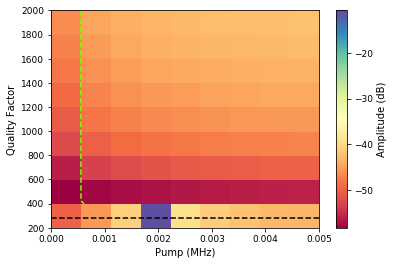

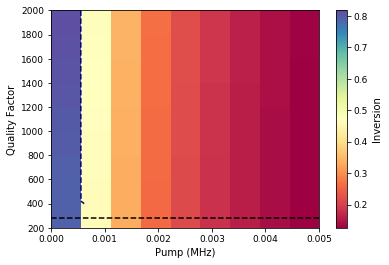

In [21]:
plt.close('all')
matplotlib.interactive(False)
fig = plt.figure()
# plt.yscale('log')
# plt.xscale('log')
plt.xlabel('Pump (MHz)')
#plt.ylabel('$\mathrm{g_{coll}}$ (MHz)')
plt.ylabel(iterate_label)


c = plt.pcolor(pump_array/2/np.pi, iterate_array/iterate_scale_value,
               10*np.log10((abs(losa2steady_maser_cum))), cmap='Spectral')

# plt.plot([0, pump_array[-1]/2/np.pi],
#         [quali, quali], 'k-')
cb = fig.colorbar(c)
cb.set_label("Amplitude (dB)")

idxs = np.where(coop_pump_maser < 0)
coop_pump_maser[idxs] = np.inf

plt.contour(pump_array/2/np.pi, iterate_array/iterate_scale_value,
            coop_pump_maser, levels=(1,), colors='lawngreen', linestyles='--')

plt.plot([pump_array[0]/2/np.pi, pump_array[-1]/2/np.pi],
         [asymp, asymp], 'k--')

# plt.savefig('/home/andreas/pump_vs_quali_amp.png')

fig = plt.figure()
plt.xlabel('Pump (MHz)')
#plt.ylabel('$\mathrm{g_{coll}}$ (MHz)')
plt.ylabel(iterate_label)
c = plt.pcolormesh(pump_array/2/np.pi, iterate_array/iterate_scale_value,
                   losszsteady_maser_cum-1, cmap='Spectral')
# plt.yscale('log')
# plt.xscale('log')
#level = 0.2
# cs = plt.contour(pump_array/2/np.pi, quali_array,
#                 losszsteady_maser, levels=(-level, level), colors='k', linestyles='-')
#labels = plt.clabel(cs, (level, -level), inline=True, fontsize=8)
#
#[l.set_rotation(0) for l in labels]
cb = fig.colorbar(c)
cb.set_label("Inversion")
plt.contour(pump_array/2/np.pi, iterate_array/iterate_scale_value,
            coop_pump_maser, levels=(1,), colors='navy', linestyles='--')

plt.plot([pump_array[0]/2/np.pi, pump_array[-1]/2/np.pi],
         [asymp, asymp], 'k--')

# plt.plot([pump_array[0], pump_array[-1]/2/np.pi],
#         [quali, quali], 'k-')
# plt.savefig('/home/andreas/pump_vs_quali_inv.png')
if not np.isnan(asymp):
    print("minimum value is: %.3f %s" % (asymp.real, iterate_unit))
plt.show()
# %qtconsole

In [22]:
deltaarr_cum = np.linspace(0, 1000e-6, 100)*2*np.pi
a2_spec = np.zeros(len(deltaarr_cum))

pump0 = pump_array[0]
iterate0 = iterate_array[-1]


nbar = 0
kappa_loop = np.pi*fr/quali
gcoll_loop = gcoll
gammaq_loop = gammaq

ctr = 0
for i, det in enumerate(deltaarr_cum):

    if to_iterate == 'quality':
        kappa_loop = np.pi*fr/iterate0
    elif to_iterate == 'temperature':
        nbar = get_thermal_photons(fr, iterate0)
    elif to_iterate == 'coupling':
        gcoll_loop = iterate0
    elif to_iterate == 'linewidth':
        gammaq_loop = iterate0

    print("Calculating %d from %d" % (ctr+1, len(deltaarr_cum)), end="\r")
    ret, infodict, ier, message = ada_steady_maser_cumulant_with_filter_cav(nbar, pump_up, deltac, gs_loop,
                                                                            spins_loop, gpar+pump_down, gperp, kappa_loop, kappa_f, g_f, det, newinit)
    a2_spec[i] = ret[0].real
    newinit = ret
    ctr += 1

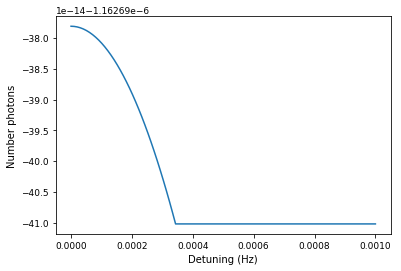

In [34]:
plt.close('all')
matplotlib.interactive(False)
fig = plt.figure()

plt.plot(deltaarr_cum/2/np.pi, a2_spec)
plt.xlabel("Detuning (Hz)")
plt.ylabel("Number photons")
plt.show()